In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("./modules/") # for d3plus2

sys.path.append("./../Hidalgo_Haussmann") # for HH tools
from HH_tools import *

import d3plus2 as d3plus

import numpy as np

import geopandas as gpd

In [2]:
path = './data/disagg_struct_refs/sources/US/'
agglevel_titles = pd.read_csv(path+'agglevel_titles.csv')
area_titles = pd.read_csv(path+'area_titles.csv')
industry_titles = pd.read_csv(path+'industry_titles.csv')
industry_titles =  pd.DataFrame([['POPESTIMATE2010','Population']], columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)
industry_titles =  pd.DataFrame([['Cropland','Cropland'],
                                ['Desert','Desert'],
                                ['Grassland','Grassland'],
                                ['Other','Other'],
                                ['Woodland','Woodland'],
                                ['Urban','Urban'],
                                ['Water','Water']], columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)
industry_titles =  pd.DataFrame([['ALAND','Area'],
                                ['pop_dens','Population density']],
                                 columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)

In [3]:
# df_cnt = df.loc[df.agglvl_code == 76]
# df_msa = df.loc[df.agglvl_code == 46]
df_cnt = pd.read_csv('./data/naics_area_cnt_02_07.csv', index_col=[0, 1])
df_msa = pd.read_csv('./data/naics_area_msa_02_07.csv', index_col=[0, 1])
df_stt = pd.read_csv('./data/naics_area_stt_02_07.csv', index_col=[0, 1])

### Population and land uses

In [4]:
# Add population
county_LU = pd.read_csv('./data/US_land_use/land_use_frac.csv', index_col=0)
county_LU.index = county_LU.index.astype(str).str.zfill(5)

In [5]:
# plt.hist(log10(county_LU['Woodland']).dropna(), 50)
# plt.show()

In [6]:
# Add population

county_pop = pd.read_csv('./data/co-est2017-alldata.csv', encoding = 'latin-1')
county_pop['area_fips'] = county_pop.STATE.astype(str).str.zfill(2) + county_pop.COUNTY.astype(str).str.zfill(3)

county_pop = county_pop[['area_fips', 'POPESTIMATE2010']].set_index('area_fips')

In [7]:
# county_ = gpd.read_file('./data/US_land_use/na70_lushp.shp')
counties = gpd.read_file('./data/cb_2017_us_county_500k/cb_2017_us_county_500k.shp')
counties['area_fips'] = counties.STATEFP + counties.COUNTYFP
counties_area = counties.set_index('area_fips')[['ALAND']]/1e6

### Industries info

In [8]:
# X = df_stt.unstack()['annual_avg_estabs']
# X = df_msa.unstack()['annual_avg_estabs']
X = df_cnt.unstack()['annual_avg_estabs']
X.columns = X.columns.astype(str)
X.index = X.index.astype(str).str.zfill(5)

X.shape

(3272, 318)

In [9]:
# X = pd.concat([county_pop.loc[X.index], county_LU.loc[X.index], X], axis = 1, sort = True)

In [10]:
X_vars = pd.concat([county_pop.loc[X.index], county_LU.loc[X.index], counties_area.loc[X.index]], axis = 1, sort = True).dropna()
X_vars['pop_dens'] = np.log10(X_vars['POPESTIMATE2010'] / X_vars['ALAND'])

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


In [11]:
# X = X.drop('ALAND', axis = 1)
X = pd.concat([X_vars, X], axis = 1, sort = True)

### Covariance Matrix

In [12]:
cor_mat = log10(X).corr(min_periods = 20)
cov_mat = log10(X).cov(min_periods = 20)

./../Hidalgo_Haussmann/HH_tools.py:58: RuntimeWarning: divide by zero encountered in log10
  return np.log10(df).replace(-np.inf, np.nan)
./../Hidalgo_Haussmann/HH_tools.py:58: RuntimeWarning: invalid value encountered in log10
  return np.log10(df).replace(-np.inf, np.nan)


In [13]:
def demean(Z):
    Z = Z.fillna(0)
    means = Z.mean()
    return (Z.T - means).T - means + means.mean()

def stand(Z):
    Z = Z.fillna(0)
    std = Z.std()
    return Z.T.div(std).T.div(std)

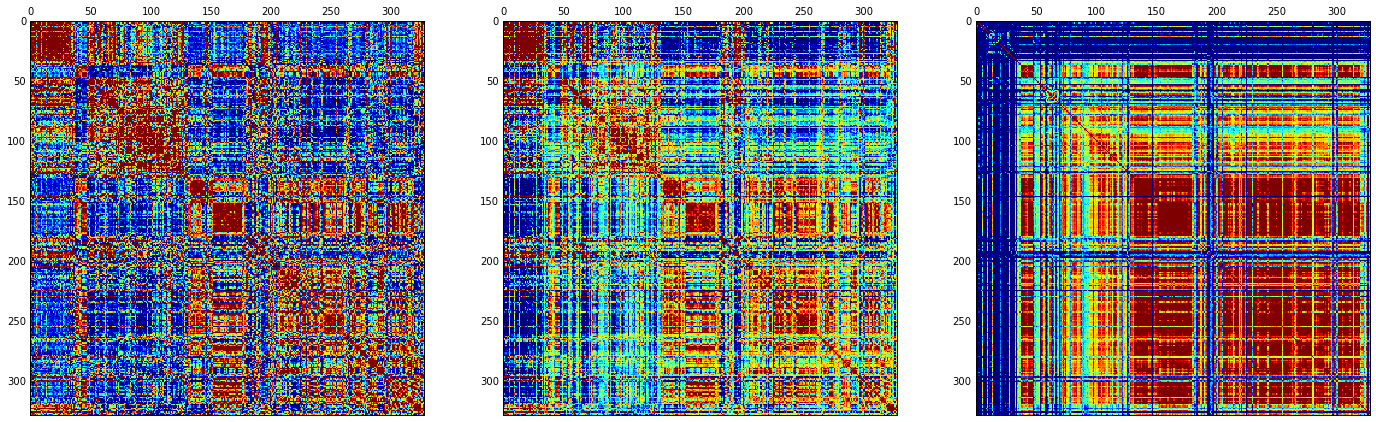

In [14]:
# mat = demean(cor_mat.fillna(0))
# mat = cor_mat
fig, axs = plt.subplots(1, 3, figsize = (24, 8))

axs[0].matshow(demean(stand(demean(cor_mat))), vmin = -10, vmax = 10)
axs[1].matshow(demean(cor_mat), vmin = -.1, vmax = .1)
axs[2].matshow(cor_mat.fillna(0), vmin = .2, vmax = .7)

# plt.hist(stand(demean(cor_mat)).std(), 30)
# plt.show()

In [15]:
# Try spectral clustering. Works when matrix is demeaned
from sklearn.cluster import SpectralClustering

X_ = demean(cor_mat)
# X_ = demean(stand(demean(cor_mat)))

clustering = SpectralClustering(n_clusters=10,
        assign_labels="discretize",
        random_state=0).fit(X_.values)

pd.options.display.max_rows = 500
clust_result = pd.DataFrame(clustering.labels_, index = X.columns, columns = ['cluster'])
clust_result = pd.concat([clust_result, industry_titles.set_index('industry_code')], axis = 1, sort = False).dropna().sort_values(by = ['cluster', 'industry_title'])

/home/miglesia/anaconda2/lib/python2.7/site-packages/sklearn/cluster/spectral.py:442: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


In [16]:
edges = pd.DataFrame(demean(cor_mat).stack(), columns = ['dem_corr'])
# edges = pd.DataFrame(demean(stand(demean(cor_mat))).stack(), columns = ['dem_corr'])
# > demean(cor_mat).values, 90
# edges.loc[]
edges_s = edges.loc[edges.dem_corr > edges.dem_corr.quantile(.925)]
edges_s.index.names = ['industry_code_x', 'industry_code_y']
edges_s = edges_s.reset_index().merge(
    industry_titles, left_on = 'industry_code_x', right_on = 'industry_code').merge(
    industry_titles, left_on = 'industry_code_y', right_on = 'industry_code').T.drop_duplicates().T
edges_s['dem_corr'] = edges_s['dem_corr'].astype(float)

In [17]:
# #Load modules
# from numpy.random import choice 
# from numpy import where, power

In [58]:
import matplotlib.colors as mcolors

# nodes = industry_titles

nodes_size = pd.DataFrame(np.sqrt(X.sum()), columns=['sqrt_size'])
nodes = pd.concat([nodes_size, clust_result], axis = 1, sort = False)

norm = mcolors.Normalize(vmin=0, vmax=10, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.gist_ncar)

nodes['color'] = nodes['cluster'].apply(lambda x: mcolors.rgb2hex(mapper.to_rgba(x)))

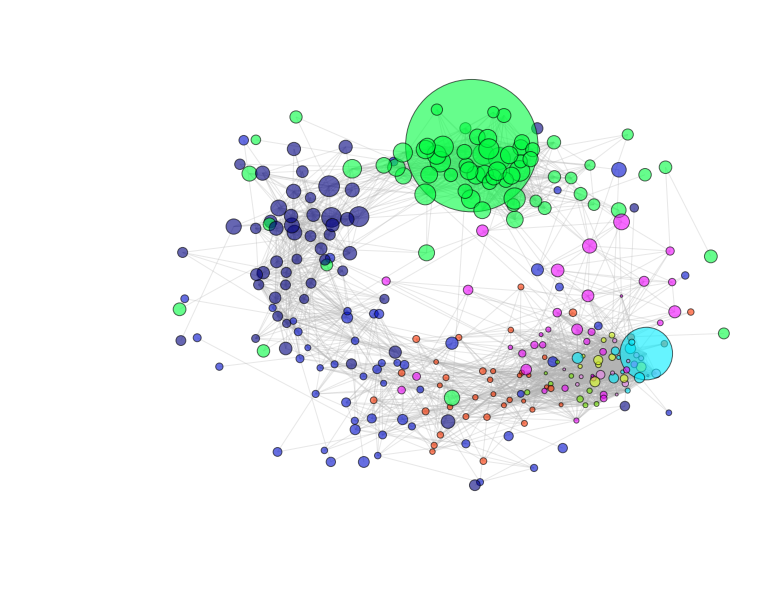

In [59]:
max_d = 40
weight_column = 'dem_corr' #'weight_'+geo

        ### Max degree = max_d. Parameter used to trim the network.
df1 = edges_s.groupby('industry_code_x').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
df2 = edges_s.groupby('industry_code_y').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
edges_max_d = df1.merge(df2, on = ['industry_code_x', 'industry_title_x', 'industry_code_y', 'industry_title_x', weight_column]).reset_index(drop = True)

###

# Hard threshold and max degree backboning

G = nx.from_pandas_edgelist(edges_max_d, 'industry_code_x', 'industry_code_y', weight_column)


plt.figure(figsize = (10, 8))

G = max(nx.connected_component_subgraphs(G), key=len)
nodes_s = nodes.loc[G.nodes.keys()]
pos = nx.spring_layout(G, k=.43)

nx.draw(G, pos, node_size = nodes_s.sqrt_size.values, alpha=.6, node_color= list(nodes_s.color.values), edgelist = [])
nx.draw_networkx_edges(G, pos, edge_color='.7', alpha=.3)
# plt.title('max_d = '+str(max_d))
#     plt.savefig('./Figures/5_max_deg/'+col_name+'_plot1.png')
#             plt.show()

plt.show()

### Draw in d3plus

In [60]:
# nodes
pos_df = pd.DataFrame(pos, index = ['x', 'y']).T
nodes_wpos = pd.concat([nodes_s, pos_df], axis = 1, sort = False)

In [61]:
nodes_ = nodes_wpos.reset_index()[['index','x', 'y', 'industry_title', 'color']].dropna(subset = ['x']).rename({'index': 'id'}, axis = 1)
nodes_['id'] = nodes_['id'].astype(str).str.zfill(4)
nodes_[['x', 'y']] = 500 * nodes_[['x', 'y']]


In [62]:
nodes_.head()

,id,x,y,industry_title,color
0,1142,255.440000,-106.399887,NAICS 1142 Hunting and trapping,#ec84ef
1,5173,-144.345944,2.158588,NAICS 5173 Wired and wireless telecommunications carriers,#000080
2,5171,121.025441,446.488965,NAICS12 5171 Wired telecommunications carriers,#000080
3,1141,235.197798,-135.431995,NAICS 1141 Fishing,#f107ff
4,3335,-112.676383,-311.847928,NAICS 3335 Metalworking machinery manufacturing,#000ecd


In [63]:
# nodes_.sort_values(by = 'id')#.loc[nodes_.id == 'Desert']

In [64]:
import sys
sys.path.append("./../Hidalgo_Haussmann") # for HH tools
import pandas as pd
from HH_tools import robust_proximity, year_to_tp, RCA

In [65]:
nodes_['presence'] = True

edges_max_d['edge_tuple'] = list(zip(edges_max_d.industry_code_x, edges_max_d.industry_code_y))
edges_max_d['edge_tuple_rev'] = list(zip(edges_max_d.industry_code_y, edges_max_d.industry_code_x))
edges_max_d_triangles = edges_max_d.loc[edges_max_d.edge_tuple.isin(G.edges()) | edges_max_d.edge_tuple_rev.isin(G.edges())]

links = edges_max_d_triangles.reset_index().rename({weight_column: 'strength'},axis = 1)
links['target'] = links['industry_code_y'].astype(str).str.zfill(4)
links['source'] = links['industry_code_x'].astype(str).str.zfill(4)

# links = nc_backbone.reset_index().rename({'score': 'strength'},axis = 1)
# links['target'] = links['trg'].astype(str).str.zfill(4)
# links['source'] = links['src'].astype(str).str.zfill(4)

network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'
# network

In [66]:
## Conditional coloring

# Manufacturing (light_blue) and services (yellow)
nodes_['color_mfg_srv'] = 'D3D3D3' #Gray bckg

conditions = [
    (nodes_['industry_title'].str.lower().str.contains('manufacturing')) + (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (nodes_['industry_title'].str.lower().str.contains('service')),# or (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (nodes_['industry_title'].str.lower().str.contains('wholesale')),# or (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (-nodes_['industry_title'].str.lower().str.contains('naics'))]

choices = ['#000080', '#ffc400', '#00b0ff', '#000000']

nodes_['color_mfg_srv'] = np.select(conditions, choices, default='#D3D3D3')


In [67]:
edges_max_d_triangles.to_csv('edges_max_d_triangles.csv', index = False)

In [68]:
nodes_.dropna().shape

(290, 7)

In [77]:
ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color="color_mfg_srv",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

<IPython.core.display.Javascript object>

In [78]:
ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color="color",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

<IPython.core.display.Javascript object>

In [74]:
nodes.groupby('cluster').color.unique()

cluster
0.0    [#000080]
1.0    [#000ecd]
2.0    [#00edff]
3.0    [#00fd3f]
4.0    [#74e800]
5.0    [#dbff20]
7.0    [#ff3400]
8.0    [#f107ff]
9.0    [#ec84ef]
Name: color, dtype: object

### Activities by cluster

In [71]:
# Save total establishments by spectral analysis cluster, and county:
# xx
X_area_cluster = pd.concat([nodes[['cluster']], X.T], axis = 1)
X_area_cluster = X_area_cluster.iloc[8:]
X_area_cluster = X_area_cluster.groupby('cluster').sum().T
X_area_cluster.to_csv('./data/X_county_cluster.csv')

X_area_cluster.head()

cluster,0.0,1.0,2.0,3.0,4.0,5.0,7.0,8.0,9.0
01001,72.233333,34.784305,1545.214693,578.283333,0.0,4.400000,3.633333,54.450000,0.600000
01003,577.383333,210.514734,4133.605847,3437.600000,19.4,14.700000,18.150000,155.950000,2.266667
01005,48.400000,35.493096,2294.544656,368.850000,1.2,17.800000,4.200000,56.600000,5.800000
01007,22.816667,30.001894,1613.365763,175.300000,0.0,16.533333,0.666667,40.433333,1.600000
01009,61.950000,57.919364,1673.479465,493.016667,0.0,4.400000,5.633333,66.550000,0.000000


In [33]:
pd.set_option('display.max_colwidth', -1)
summary = nodes.loc[nodes.industry_title.str.contains('NAICS')].groupby('cluster').apply(lambda x: x.sample(3))#.agg({'industry_title': 'first', 'color':[ 'first', 'count']})
# summary.columns = ['color', 'node_count','example']
summary.sort_index()#.sort_values(by = 'node_count')

sqrt_size  cluster  \
cluster                             
0.0     5241  196.439473  0.0       
        7115  132.758302  0.0       
        8132  104.059118  0.0       
1.0     2373  126.300501  1.0       
        3279  51.802510   1.0       
        7131  46.720445   1.0       
2.0     1124  16.112624   2.0       
        1125  25.565602   2.0       
        1132  15.152008   2.0       
3.0     6212  340.223872  3.0       
        6241  216.479599  3.0       
        8141  721.109192  3.0       
4.0     3117  28.724554   4.0       
        3131  21.306102   4.0       
        4831  27.416844   4.0       
5.0     1131  23.496454   5.0       
        3211  59.307672   5.0       
        4862  33.399102   5.0       
7.0     3311  27.126555   7.0       
        3322  37.375571   7.0       
        4851  30.321884   7.0       
8.0     3122  15.359579   8.0       
        9211  202.831252  8.0       
        9231  114.098349  8.0       
9.0     1122  40.824625   9.0       
        4245  75.811938   9.0       
        5211  15.387766   9.0       

                                                        industry_title  \
cluster                                                                  
0.0     5241  NAICS 5241 Insurance carriers                              
        7115  NAICS 7115 Independent artists, writers, and performers    
        8132  NAICS 8132 Grantmaking and giving services                 
1.0     2373  NAICS 2373 Highway, street, and bridge construction        
        3279  NAICS 3279 Other nonmetallic mineral products              
        7131  NAICS 7131 Amusement parks and arcades                     
2.0     1124  NAICS 1124 Sheep and goat farming                          
        1125  NAICS 1125 Aquaculture                                     
        1132  NAICS 1132 Forest nursery and gathering forest products    
3.0     6212  NAICS 6212 Offices of dentists                             
        6241  NAICS 6241 Individual and family services                  
        8141  NAICS 8141 Private households                              
4.0     3117  NAICS 3117 Seafood product preparation and packaging       
        3131  NAICS 3131 Fiber, yarn, and thread mills                   
        4831  NAICS 4831 Sea, coastal, and great lakes transportation    
5.0     1131  NAICS 1131 Timber tract operations                         
        3211  NAICS 3211 Sawmills and wood preservation                  
        4862  NAICS 4862 Pipeline transportation of natural gas          
7.0     3311  NAICS 3311 Iron and steel mills and ferroalloy mfg.        
        3322  NAICS 3322 Cutlery and handtool manufacturing              
        4851  NAICS 4851 Urban transit systems                           
8.0     3122  NAICS 3122 Tobacco manufacturing                           
        9211  NAICS 9211 Executive, legislative and general government   
        9231  NAICS 9231 Administration of human resource programs       
9.0     1122  NAICS 1122 Hog and pig farming                             
        4245  NAICS 4245 Farm product raw material merch. whls.          
        5211  NAICS 5211 Monetary authorities - central bank             

                color  
cluster                
0.0     5241  #000080  
        7115  #000080  
        8132  #000080  
1.0     2373  #0000f1  
        3279  #0000f1  
        7131  #0000f1  
2.0     1124  #004cff  
        1125  #004cff  
        1132  #004cff  
3.0     6212  #00b0ff  
        6241  #00b0ff  
        8141  #00b0ff  
4.0     3117  #29ffce  
        3131  #29ffce  
        4831  #29ffce  
5.0     1131  #7dff7a  
        3211  #7dff7a  
        4862  #7dff7a  
7.0     3311  #ffc400  
        3322  #ffc400  
        4851  #ffc400  
8.0     3122  #ff6800  
        9211  #ff6800  
        9231  #ff6800  
9.0     1122  #f10800  
        4245  #f10800  
        5211  #f10800

In [34]:
nodes_['color'].value_counts().index

Index([u'#00b0ff', u'#0000f1', u'#000080', u'#ffc400', u'#ff6800', u'#f10800',
       u'#7dff7a', u'#004cff', u'#29ffce'],
      dtype='object')

In [35]:
# land-use clusters
nodes_.loc[nodes_['color'].isin(['#f10800', '#ff6800', '#ceff29', '#29ffce'])].sort_values(by = ['color','industry_title'])

#population cluster
nodes_.loc[nodes_['color'].isin(['#7dff7a'])].sort_values(by = ['color','industry_title'])

#'yellow' services cluster
nodes_.loc[nodes_['color'].isin(['#ffc400'])].sort_values(by = ['color','industry_title'])

#state/public sector cluster
# nodes_.loc[nodes_['color'].isin(['#004cff'])].sort_values(by = ['color','industry_title'])

#others/mfg clusters
# nodes_.loc[nodes_['color'].isin(['#000080', '#0000f1', '#00b0ff'])].sort_values(by = ['industry_title'])

# coastal?
# nodes_.loc[nodes_['color'].isin(['#0000f1'])].sort_values(by = ['color','industry_title'])

,id,x,y,industry_title,color,presence,color_mfg_srv
196,2212,-197.767523,323.127130,NAICS 2212 Natural gas distribution,#ffc400,True,#D3D3D3
152,3115,-155.535076,355.667241,NAICS 3115 Dairy product manufacturing,#ffc400,True,#000080
273,3116,-144.390033,125.899149,NAICS 3116 Animal slaughtering and processing,#ffc400,True,#D3D3D3
274,3132,-134.771857,223.421395,NAICS 3132 Fabric mills,#ffc400,True,#D3D3D3
49,3133,-66.613131,170.540593,NAICS 3133 Textile and fabric finishing mills,#ffc400,True,#D3D3D3
166,3159,-13.543043,186.887825,NAICS 3159 Accessories and other apparel manufacturing,#ffc400,True,#000080
165,3162,-48.407564,261.947066,NAICS 3162 Footwear manufacturing,#ffc400,True,#000080
161,3169,-93.369328,209.512940,NAICS 3169 Other leather product manufacturing,#ffc400,True,#000080
66,3241,-244.166635,317.361431,NAICS 3241 Petroleum and coal products manufacturing,#ffc400,True,#000080
25,3251,24.442592,164.085296,NAICS 3251 Basic chemical manufacturing,#ffc400,True,#000080


### Keywords by cluster

In [36]:
# Cluster 7, #ffc400 are 76 nodes that follow neither population nor land resources. Then what is it all about?
from collections import Counter
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 

from IPython.display import display, HTML
import colorlover as cl    
    
for clsr in range(10):
    try:
        
        text = nodes.loc[nodes.cluster == clsr]['industry_title']

        r1 = text.str.lower().str.split().values
        r1 = [item for sublist in r1 for item in sublist]

        r1_f = [w.replace(',', '').replace('mfg.', 'manufacturing') for w in r1 if not w in stop_words] 

        print(summary.loc[clsr])
        color = summary.loc[clsr]['color']
        display(HTML(cl.to_html( [tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))] )))
        print(Counter(r1_f).most_common()[:10])
        print('\n')
    except:
        pass

       sqrt_size  cluster  \
8132  104.059118  0.0       
5241  196.439473  0.0       
7115  132.758302  0.0       

                                               industry_title    color  
8132  NAICS 8132 Grantmaking and giving services               #000080  
5241  NAICS 5241 Insurance carriers                            #000080  
7115  NAICS 7115 Independent artists, writers, and performers  #000080  
       sqrt_size  cluster  \
3279  51.802510   1.0       
2373  126.300501  1.0       
7131  46.720445   1.0       

                                           industry_title    color  
3279  NAICS 3279 Other nonmetallic mineral products        #0000f1  
2373  NAICS 2373 Highway, street, and bridge construction  #0000f1  
7131  NAICS 7131 Amusement parks and arcades               #0000f1  
      sqrt_size  cluster  \
1125  25.565602  2.0       
1124  16.112624  2.0       
1132  15.152008  2.0       

                                               industry_title    color  
1125  NAICS 

### Map distribution from different clusters

In [37]:
# nodes
import geopandas as gpd

counties = gpd.read_file('./data/cb_2017_us_county_500k/cb_2017_us_county_500k.shp')
counties['area_fips'] = counties.STATEFP + counties.COUNTYFP


In [ ]:
### A little trick. Distribution of neigbors of node 'Naics 5417 Scientific Research and Development Services'
# nodes_.loc[nodes_.id == '5417']
ego_node = 'Desert' #'Cropland' #'POPESTIMATE2010'# '5417'

neigh = edges_max_d_triangles.loc[(edges_max_d_triangles.industry_code_x == ego_node) |
                                  (edges_max_d_triangles.industry_code_y == ego_node)]
neigh_ids = list(set(neigh['industry_code_x'].unique()).union(set(neigh['industry_code_y'].unique())))
# nodes_.loc[nodes_.id.isin(neigh_ids)]['id'].values

node_ids = neigh_ids

In [ ]:
# gdf.loc[gdf.industry_code == naics]['annual_avg_estabs']
# df_neigh
# df_neigh.groupby('industry_code').mean().sort_values(by = 'annual_avg_estabs').tail(5).index

In [ ]:
from PIL import Image, ImageDraw, ImageFont


In [ ]:
# Choose indus to process...
n = 5
merged = df_agglv_yravg.groupby(level = 1)['annual_avg_estabs'].sum().reset_index().merge(nodes_, left_on = 'industry_code', right_on = 'id')
display_indus = merged.loc[merged.groupby('color')['annual_avg_estabs'].nlargest(n).index.get_level_values(1)]

#Filter original data to have these neighboring industries
df_agglv = df.loc[df.agglvl_code == 76]

df_agglv_yravg = df_agglv.groupby(['area_fips', 'industry_code']).mean().drop(['agglvl_code','year'], axis = 1)
# df_indu_prc_area = df_agglv_yravg.groupby(level=0).apply(lambda x: 100 * x / x.sum())
df_indu_prc_area = log10(df_agglv_yravg)

df_ = df_indu_prc_area.reset_index()

i = 0
open('./Figures/7_compo_USA_nw/labels.txt', 'w').close()
for color in nodes_.color.unique():
  
    cluster_ids = nodes_.loc[nodes_.color == color]['id']
    node_ids = cluster_ids.values
    
    df_neigh = df_.loc[df_.industry_code.isin(nodes_.loc[nodes_.id.isin(node_ids)]['id'].values)]
    df_neigh = df_neigh.set_index('area_fips')
    
    counties_ = counties.set_index('area_fips').reindex(df_neigh.index)[['geometry']]
    gdf = gpd.GeoDataFrame(pd.concat([df_neigh, counties_], axis = 1, sort = True).dropna())

    # Sample of cluster color
    rgb_tuple = tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))
    im = Image.new('RGBA', (20, 20), rgb_tuple)
    im.save('./Figures/7_compo_USA_nw/cp_'+str(i)+'.png')

    for naics in display_indus['industry_code'].values:
        if( gdf.loc[gdf.industry_code == naics]['annual_avg_estabs'].mean() > .2 ):#& (i <=5): # Dismiss small indus
            node_info = nodes_.loc[nodes_.id == naics]
            
            # send node labels to test (they will then go to svg of figure)
            with open('./Figures/7_compo_USA_nw/labels.txt', 'a') as f:
                f.write(node_info['industry_title'].values[0]+'\n')
            display(node_info)
            display(HTML(cl.to_html( [rgb_tuple] )))

            ax = gdf.loc[gdf.industry_code == naics].plot(
                column='annual_avg_estabs', cmap=plt.cm.gist_yarg, vmin = 0, vmax = 1.5, linewidth = 0, figsize = (10, 6.5))
            ax.set_xlim(-130, -60)
            ax.set_ylim(22, 50)#, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
#             plt.axis('off')
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            plt.text(-128, 23.5, 'NAICS '+str(node_info['id'].values[0]), fontsize=30) # position in lat lon
            plt.savefig('./Figures/7_compo_USA_nw/'+str(node_info['id'].values[0])+'.png', bbox_inches = 'tight')
            plt.show()
    i+=1

In [ ]:
# TXT2InkscapeXMLv3.py

# A simple Python 3 script to look through a list of text and
# turn each line into an xml entry for use in Inkscape.
# in this script we will slightly spread the text to allow
# the user a better chance of retaining the order of their
# initial text.  Inkscape can be used to spread it out
# using the Align and Distribute Tool.


ofilenm = './Figures/7_compo_USA_nw/figure.svg'#str(input("What is the filename you wish for output?"))
outfile = open(ofilenm,"w")

ListFlm = './Figures/7_compo_USA_nw/labels.txt'#str(input("What is the name and location of the TXT file to work with?"))

Loctn = 75 #Vertical position to start text insertion
SpacingV = 25  #The vertical spacing between lines.

# The block that follows is the Inkscape standard header.
TextBlockA = '''<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!-- Created with Inkscape (http://www.inkscape.org/) -->

<svg
   xmlns:dc="http://purl.org/dc/elements/1.1/"
   xmlns:cc="http://creativecommons.org/ns#"
   xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
   xmlns:svg="http://www.w3.org/2000/svg"
   xmlns="http://www.w3.org/2000/svg"
   xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd"
   xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape"
   width="744.09448819"
   height="1052.3622047"
   id="svg2"
   version="1.1"
   inkscape:version="0.48.4 r9939"
   sodipodi:docname="New document 1">
  <defs
     id="defs4" />
  <sodipodi:namedview
     id="base"
     pagecolor="#ffffff"
     bordercolor="#666666"
     borderopacity="1.0"
     inkscape:pageopacity="0.0"
     inkscape:pageshadow="2"
     inkscape:zoom="0.35"
     inkscape:cx="375"
     inkscape:cy="520"
     inkscape:document-units="px"
     inkscape:current-layer="layer1"
     showgrid="false"
     inkscape:window-width="1280"
     inkscape:window-height="742"
     inkscape:window-x="-2"
     inkscape:window-y="-3"
     inkscape:window-maximized="1" />
  <metadata
     id="metadata7">
    <rdf:RDF>
      <cc:Work
         rdf:about="">
        <dc:format>image/svg+xml</dc:format>
        <dc:type
           rdf:resource="http://purl.org/dc/dcmitype/StillImage" />
        <dc:title></dc:title>
      </cc:Work>
    </rdf:RDF>
  </metadata>
  <g
     inkscape:label="Layer 1"
     inkscape:groupmode="layer"
     id="layer1">'''

TextBlockB = '''<text\n
        xml:space="preserve"
        style="font-size:20px;font-style:normal;font-weight:normal;line-height:125%;letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;font-family:Sans"
        x="93.910118"
        y="'''
TextBlockC = '''id="text2989"
        sodipodi:linespacing="150%"><tspan
            sodipodi:role="line"
            id="tspan2991"
            x="93.910118"
            y="'''

outfile.write(TextBlockA)

# The section that follows is to build the SVG text elements
f = open(ListFlm,"r")
for line in f:
    TXTLine = line.strip()
    Loctn = Loctn + SpacingV
    InsertStrng1 = str(Loctn)+'"\n'
    InsertStrng2= str(Loctn)+'">'+TXTLine+'</tspan></text>\n'
    outfile.write(TextBlockB)
    outfile.write(InsertStrng1)
    outfile.write(TextBlockC)
    outfile.write(InsertStrng2)

# The next section is the close off for the SVG xml.

outfile.write('  </g>\n')
outfile.write('</svg>\n')

outfile.close()
print("Done")

In [ ]:
# Choose indus to process...
n = 5
merged = df_agglv_yravg.groupby(level = 1)['annual_avg_estabs'].sum().reset_index().merge(nodes_, left_on = 'industry_code', right_on = 'id')
display_indus = merged.loc[merged.groupby('color')['annual_avg_estabs'].nlargest(n).index.get_level_values(1)]

#Filter original data to have these neighboring industries
df_agglv = df.loc[df.agglvl_code == 76]

df_agglv_yravg = df_agglv.groupby(['area_fips', 'industry_code']).mean().drop(['agglvl_code','year'], axis = 1)
# df_indu_prc_area = df_agglv_yravg.groupby(level=0).apply(lambda x: 100 * x / x.sum())
df_indu_prc_area = log10(df_agglv_yravg)

df_ = df_indu_prc_area.reset_index()

for color in nodes_.color.unique():
  
    cluster_ids = nodes_.loc[nodes_.color == color]['id']
    node_ids = cluster_ids.values
    
    df_neigh = df_.loc[df_.industry_code.isin(nodes_.loc[nodes_.id.isin(node_ids)]['id'].values)]
    df_neigh = df_neigh.set_index('area_fips')
    
    counties_ = counties.set_index('area_fips').reindex(df_neigh.index)[['geometry']]
    gdf = gpd.GeoDataFrame(pd.concat([df_neigh, counties_], axis = 1, sort = True).dropna())
    
    for naics in display_indus['industry_code'].values:
        if( gdf.loc[gdf.industry_code == naics]['annual_avg_estabs'].mean() > .45 ):#& (i <=5): # Dismiss small indus
            display(nodes_.loc[nodes_.id == naics])
            display(HTML(cl.to_html( [tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))] )))

            ax = gdf.loc[gdf.industry_code == naics].plot(
                column='annual_avg_estabs', cmap=plt.cm.gist_yarg, vmin = 0, vmax = 1.5, linewidth = 0, figsize = (10, 6.5))
            ax.set_xlim(-130, -60)
            ax.set_ylim(22, 50)#, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
            plt.show()
            i+=1

### Color by Population Density

In [ ]:
processed_data_path = './../../../../../media/miglesia/Elements/corr_st_data/'

main_tables = pd.concat([pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2011_2012.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2011_2013.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2012_2013.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2011.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2012.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2013.csv')])

main_table = main_tables.groupby('CHI ID COM').mean()/2.

# change node names into node index
# main_table.rename(columns = dict(zip(nodes.node_name, nodes.index)), inplace = True)

population = pd.read_csv('./data/pop_dist_comuna.csv').rename(columns = {'comuna_id': 'CHI ID COM'})

In [ ]:
from numpy import log10
population['log_dens'] = log10(population['densidad'])
b = 8; population['log_dens_cat'] = pd.cut(population['log_dens'], b)

bins = pd.cut(population['log_dens'], b, retbins=True)[1]
bins_mean = (bins[1:] + bins[:-1])/2.

merged = pd.concat([population.set_index('CHI ID COM')[['log_dens_cat']].sort_index(), main_table], axis = 1)
popdens_RCA = RCA(merged.groupby('log_dens_cat').sum())

popdens_RCA_normed = popdens_RCA/popdens_RCA.sum()

In [ ]:
nodes_

In [ ]:
# pop_dens_index = pd.DataFrame((popdens_RCA_normed.T*bins_mean).T.sum(), columns = ['pop_dens_index'])
# pop_dens_index = pop_dens_index.reset_index().rename(columns={'index':'id'})
# nodes_ = nodes_.merge(pop_dens_index, on = 'id', how = 'left') # industry_title / node_name
# # nodes_['pop_dens_color_code'] = pd.cut(nodes_['pop_dens_index'], bins = 7, labels=False)

# from numpy import nan
# rainbow_colors = {0:'#9400D3', #Violet
# 1:'#4B0082', #Indigo
# 2:'#0000FF', #Blue
# 3:'#00FF00', #Green
# nan:'#D3D3D3',  #'#D3D3D3', #Gray
# 4:'#FFFF00', #Yellow
# 5:'#FF7F00', #Orange
# 6:'#FF0000'} #Red

# nodes_['color_2'] = pd.DataFrame(nodes_['pop_dens_color_code'].map(rainbow_colors))

# network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'

In [ ]:
ps = d3plus.ProductSpace(
id="name",
name="node_name",
color="color_2",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

In [ ]:
plt.hist(edges.weight_CHI_COM.values, 50)
plt.hist(edges_max_d.weight_CHI_COM.values, 50)
plt.show()